# 4.1 Onboard LED and Temperature

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AccelerationConsortium/ac-microcourses/blob/main/docs/courses/hello-world/1.4.1-onboard-led-temp.ipynb)

Ensure that you've followed the instructions in the hardware/software communication notebook to set up your Pico W microcontroller. This notebook will allow you to interact with the microcontroller via the MQTT protocol. This assumes you are using the same HiveMQ microcredentials as in this notebook (`HIVEMQ_USERNAME`, `HIVEMQ_PASSWORD`, `HIVEMQ_HOST`). Feel free to swap in your own credentials if you have them, but you will need to make sure that is changed on both the microcontroller and here, and you will need to replace the `hivemq-com-chain.der` file on the microcontroller per the Build Instructions manuscript (Step 13b).

You will also need to check that the `COURSE_ID` here matches the `COURSE_ID` on the microcontroller. This is to ensure that the microcontroller is subscribed to the correct topic.

In [9]:
# only install paho-mqtt if we are running in colab
# matplotlib only for visualization
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip install paho-mqtt matplotlib

In [10]:
COURSE_ID = "<your_id_here>" # UPDATE THIS TO YOUR ID

command_topic = f"{COURSE_ID}/onboard_led"
sensor_data_topic = f"{COURSE_ID}/onboard_temp"

HIVEMQ_USERNAME = "sgbaird"
HIVEMQ_PASSWORD = "D.Pq5gYtejYbU#L"
HIVEMQ_HOST = "248cc294c37642359297f75b7b023374.s2.eu.hivemq.cloud"

In [11]:
import paho.mqtt.client as paho
from paho import mqtt
import json
from queue import Queue

sensor_data_queue: "Queue[dict]" = Queue()

def get_paho_client(sensor_data_topic, hostname, username, password=None, port=8883, tls=True):

    client = paho.Client()  # create new instance

    def on_message(client, userdata, msg):
        sensor_data_queue.put(json.loads(msg.payload))

    # The callback for when the client receives a CONNACK response from the server.
    def on_connect(client, userdata, flags, rc, properties=None):
        if rc != 0:
            print("Connected with result code " + str(rc))
        # Subscribing in on_connect() means that if we lose the connection and
        # reconnect then subscriptions will be renewed.
        client.subscribe(sensor_data_topic, qos=1)

    client.on_connect = on_connect
    client.on_message = on_message

    # enable TLS for secure connection
    if tls:
        client.tls_set(tls_version=mqtt.client.ssl.PROTOCOL_TLS_CLIENT)
    # set username and password
    client.username_pw_set(username, password)
    # connect to HiveMQ Cloud on port 8883 (default for MQTT)
    client.connect(hostname, port)
    client.subscribe(sensor_data_topic, qos=1)

    return client


def send_and_receive(client, command_topic, msg, queue_timeout=60):
    client.publish(command_topic, msg, qos=2)

    client.loop_start()
    while True:
        sensor_data = sensor_data_queue.get(True, queue_timeout)
        client.loop_stop()
        return sensor_data

In [12]:
client = get_paho_client(
    sensor_data_topic, HIVEMQ_HOST, HIVEMQ_USERNAME, password=HIVEMQ_PASSWORD
)

Now, send a command to toggle the onboard LED on the Pico W and read the temperature from the onboard sensor using the `send_and_receive` function.

In [13]:
onboard_temp = send_and_receive(
    client, command_topic, "toggle", queue_timeout=30
)
print(onboard_temp)

KeyboardInterrupt: 

Now, run the following cell, which puts a small delay between iterative calls to the `send_and_receive` function. The onboard LED will be toggled at each iteration, and temperatures will be stored in the `onboard_temps` list. A running plot of the temperature as a function of time will be displayed. Feel free to stop the cell at any time.

Note that the time is elapsed time, which is calculated within the notebook rather than being sent by the microcontroller. Ideally, the microcontroller would record a full timestamp in UTC time and send that with the temperature data; however, to keep the hardware/software communication simpler (i.e., just a number corresponding to the temperature in degrees Celsius), sending timestamps is omitted from the example microcontroller code.

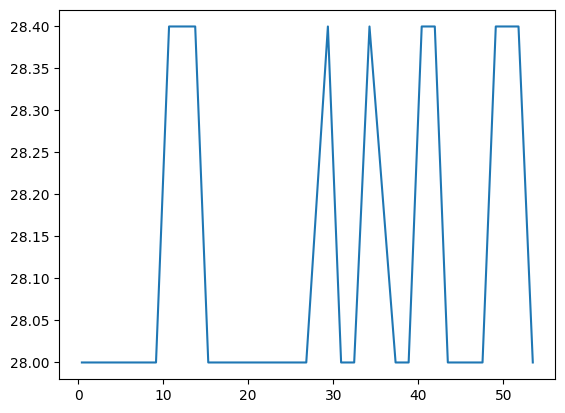

In [8]:
import matplotlib.pyplot as plt
from time import sleep, time
from IPython.display import clear_output

onboard_temps = []
timestamps = []

start_time = time()  # Get the current time

for _ in range(30):
    onboard_temp = send_and_receive(
        client, command_topic, "toggle", queue_timeout=60
    )
    onboard_temps.append(onboard_temp)
    elapsed_time = time() - start_time  # Calculate the elapsed time
    timestamps.append(elapsed_time)
    print(onboard_temp)
    sleep(1.0)

    # Update the plot
    clear_output(wait=True)  # Clear the current output
    plt.plot(timestamps, onboard_temps)  # Plot the temperatures
    plt.show()  # Show the plot